In [1]:
!pip install -Uq openai-agents tavily-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.6/130.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.4 MB/s eta 0:00:00


In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import os
from agents import Agent, Runner, AsyncOpenAI, OpenAIChatCompletionsModel
from google.colab import userdata

gemini_api_key = userdata.get("GEMINI_API_KEY")
search_api_key = userdata.get("SEARCH_API_KEY")

#Reference: https://ai.google.dev/gemini-api/docs/openai
external_client = AsyncOpenAI(
    api_key=gemini_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)

model = OpenAIChatCompletionsModel(
    model="gemini-2.0-flash",
    openai_client=external_client
)

In [4]:
from agents import set_tracing_disabled

set_tracing_disabled(True)

In [5]:
from pydantic import BaseModel
from agents import (
    Agent,
    GuardrailFunctionOutput,
    RunContextWrapper,
    Runner,
    TResponseInputItem,
    input_guardrail,
    output_guardrail,
    OutputGuardrailTripwireTriggered,

)

class TravelSafetyCheckOutput(BaseModel):
    is_unethical_or_illegal_request: bool
    reasoning: str

travel_guardrail_agent = Agent(
    name="Travel Guardrail",
    instructions=(
        "Determine if the user request involves illegal travel activity, such as crossing borders illegally, "
        "faking documents, or bypassing visa restrictions. Respond with reasoning."
    ),
    output_type=TravelSafetyCheckOutput,
    model=model # Ensure the model is used here as well
)

@input_guardrail
async def travel_guardrail(
    ctx: RunContextWrapper[None],
    agent: Agent,
    input: str | list[TResponseInputItem],
) -> GuardrailFunctionOutput:
    result = await Runner.run(travel_guardrail_agent, input, context=ctx.context)

    return GuardrailFunctionOutput(
        output_info=result.final_output,
        tripwire_triggered=result.final_output.is_unethical_or_illegal_request,
    )

In [6]:
class TripOutput(BaseModel):
    response: str

class TripSafetyCheck(BaseModel):
    reasoning: str
    contains_illegal_or_unrealistic: bool

trip_guardrail_agent = Agent(
    name="Trip Output Guardrail",
    instructions="Check if the travel plan contains illegal, unsafe, or unrealistic recommendations. Provide reasoning.",
    output_type=TripSafetyCheck,
    model=model
)

@output_guardrail
async def trip_output_guardrail(
    ctx: RunContextWrapper,
    agent: Agent,
    output: TripOutput
) -> GuardrailFunctionOutput:
    result = await Runner.run(trip_guardrail_agent, output.response, context=ctx.context)

    return GuardrailFunctionOutput(
        output_info=result.final_output,
        tripwire_triggered=result.final_output.contains_illegal_or_unrealistic,
    )

In [7]:
plan_trip_instructions = """You are a highly professional and meticulous
     trip planning agent. Your task is to generate detailed and
    well-structured itineraries based on the user's specified destination,
    duration, and interests. The itinerary should include a balanced mix of
    attractions, activities, and dining recommendations, taking into account
    geographical proximity and realistic travel times between locations. Ensure the plan is comprehensive, practical, and tailored to enhance the user's travel experience. """

In [8]:

from pydantic import BaseModel

class TripPlanOutput(BaseModel):
    response: str

plan_trip_agent=Agent(
    name="plan_trip_agent",
    instructions=plan_trip_instructions,
    model=model,
    input_guardrails=[travel_guardrail],
    output_guardrails=[trip_output_guardrail],
    output_type=TripPlanOutput
)

In [11]:
from agents import Runner
result= Runner.run_sync(plan_trip_agent,"i move usa for 30 days  " )
print(result.final_output)
print(result.to_input_list())


response='Okay, I can help you create a 30-day itinerary for your move to the USA. To make it perfect, I need a little more information. Could you tell me: \n\n1.  **What are your main interests?** (e.g., nature, history, food, city life, beaches, adventure, etc.)\n2.  **Are you planning to stay in one location or travel around to multiple states/cities?**\n3.  **What is your approximate budget for this trip?** (e.g., budget, mid-range, luxury)\n4.  **Is there a specific region or area of the US you are interested in exploring?** (e.g., West Coast, East Coast, South, Midwest)\n5.  **What time of year are you planning to travel?**\n\nOnce I have these details, I can build a detailed and personalized itinerary for your 30 days in the USA!'
[{'content': 'i move usa for 30 days  ', 'role': 'user'}, {'id': '__fake_id__', 'content': [{'annotations': [], 'text': '{\n  "response": "Okay, I can help you create a 30-day itinerary for your move to the USA. To make it perfect, I need a little more

In [12]:
class FinanceSafetyCheckOutput(BaseModel):
    is_unethical_or_illegal_request: bool
    reasoning: str

finance_guardrail_agent = Agent(
    name="Finance Guardrail",
    instructions=(
        "Determine whether the user's request contains unethical or illegal financial content, such as tax fraud, "
        "loan evasion, or unrealistic get-rich-quick schemes. Provide a reasoned judgment."
    ),
    output_type=FinanceSafetyCheckOutput,
    model=model
)

@input_guardrail
async def finance_guardrail(
    ctx: RunContextWrapper[None],
    agent: Agent,
    input: str | list[TResponseInputItem],
) -> GuardrailFunctionOutput:
    result = await Runner.run(finance_guardrail_agent, input, context=ctx.context)

    return GuardrailFunctionOutput(
        output_info=result.final_output,
        tripwire_triggered=result.final_output.is_unethical_or_illegal_request,
    )


In [13]:
budget_created_instructions=""" You are a knowledgeable and reliable financial planning agent.
 Your role is to create clear, practical monthly budget plans based on the user's income, expenses,
  and savings goals. Analyze the input to calculate spending distribution and suggest strategies
  to optimize savings, reduce unnecessary expenses, and achieve long-term financial stability.
Ensure your guidance is personalized, realistic, and easy to follow."""

In [14]:
class BudgetOutput(BaseModel):
    response: str

class BudgetSafetyCheck(BaseModel):
    reasoning: str
    contains_unethical_finance: bool

budget_guardrail_agent = Agent(
    name="Budget Output Guardrail",
    instructions="Check if the budget advice includes unethical, unsafe, or illegal financial strategies. Provide reasoning.",
    output_type=BudgetSafetyCheck,
    model=model
)

@output_guardrail
async def budget_output_guardrail(
    ctx: RunContextWrapper,
    agent: Agent,
    output: BudgetOutput
) -> GuardrailFunctionOutput:
    result = await Runner.run(budget_guardrail_agent, output.response, context=ctx.context)

    return GuardrailFunctionOutput(
        output_info=result.final_output,
        tripwire_triggered=result.final_output.contains_unethical_finance,
    )


In [15]:
budget_created_agent=Agent(
    name="budget_created_agent",
    instructions=budget_created_instructions,
    model=model,
    input_guardrails=[finance_guardrail],
    output_guardrails=[budget_output_guardrail],
    output_type=BudgetOutput
)


In [16]:
result=Runner.run_sync(budget_created_agent,"i can move USA need money " )
print(result.final_output)

response='Moving to the USA requires careful financial planning. To create a helpful budget, I need more information:\n\n1.  What is your current monthly income?\n2.  What are your current monthly expenses (rent/mortgage, utilities, food, transportation, debt payments, etc.)?\n3.  How much do you have saved currently?\n4.  What are your estimated moving costs (visa fees, flights, shipping, initial housing costs, etc.)?\n5.  What is your target savings goal for the move?\n\nOnce I have this information, I can provide a personalized budget plan, including strategies for saving, reducing expenses, and managing your finances during the move.'


In [17]:
from pydantic import BaseModel
from agents import (
    Agent,
    GuardrailFunctionOutput,
    RunContextWrapper,
    Runner,
    TResponseInputItem,
    input_guardrail,
    output_guardrail,
    OutputGuardrailTripwireTriggered,

)

class ReminderCheckOutput(BaseModel):
    reasoning: str
    # is_malicious_or_concerning: bool # This was the old name, now using contains_harmful_reminder

reminder_guardrail_agent = Agent(
    name="Reminder Guardrail",
    instructions=(
        "Check if the reminder request is potentially harmful, threatening, or abusive — such as reminders for violent acts "
        "or unethical actions. Explain your reasoning."
    ),
    output_type=ReminderCheckOutput,
    model=model
)

@input_guardrail
async def reminder_guardrail(
    ctx: RunContextWrapper[None],
    agent: Agent,
    input: str | list[TResponseInputItem],
) -> GuardrailFunctionOutput:
    result = await Runner.run(reminder_guardrail_agent, input, context=ctx.context)

    return GuardrailFunctionOutput(
        output_info=result.final_output,
        tripwire_triggered=result.final_output.contains_harmful_reminder,
    )

In [18]:
set_reminder_instructions=""" You are a precise and dependable personal assistant
specializing in task management and reminders. Your responsibility is to schedule
reminders based on the user’s specified task and date/time. Confirm all details clearly
and ensure that the reminders are timely, actionable, and unambiguous.
 Always prioritize clarity and accuracy to help users stay organized and on track."""

In [19]:
class ReminderOutput(BaseModel):
    response: str

class ReminderSafetyCheck(BaseModel):
    reasoning: str
    contains_harmful_reminder: bool

reminder_guardrail_agent = Agent(
    name="Reminder Output Guardrail",
    instructions="Check if the reminder includes anything harmful, suspicious, or unethical. Provide reasoning.",
    output_type=ReminderSafetyCheck,
    model=model
)

@output_guardrail
async def reminder_output_guardrail(
    ctx: RunContextWrapper,
    agent: Agent,
    output: ReminderOutput
) -> GuardrailFunctionOutput:
    result = await Runner.run(reminder_guardrail_agent, output.response, context=ctx.context)

    return GuardrailFunctionOutput(
        output_info=result.final_output,
        tripwire_triggered=result.final_output.contains_harmful_reminder,
    )


In [20]:
set_reminder_agent=Agent(
    name="set_reminder_agent",
    instructions=set_reminder_instructions,
    model=model,
    input_guardrails=[reminder_guardrail],
    output_guardrails=[reminder_output_guardrail],
    output_type=ReminderOutput
)

In [21]:
result=Runner.run_sync(set_reminder_agent,"i can move USA  " )
print(result.final_output)

response='I am sorry, I cannot fulfill this request. This is because it is ambiguous. I need a task and a specific date and time to set a reminder.'


In [23]:
weather_instructions=""" You are a helpful and accurate weather assistant.
Your task is to provide current or forecasted weather information for a given location and date.
Summarize conditions clearly, including temperature, precipitation, and any important alerts.
 When a date is not specified, default to today’s forecast.
Present information in a user-friendly format to help users plan their activities accordingly."""

In [24]:
from agents.tool import function_tool
from tavily import TavilyClient

@function_tool
def browse_online(query: str):
  """Search online for the given query."""
  tavily_client = TavilyClient(api_key=search_api_key)
  response = tavily_client.search(query)
  return response

In [43]:
weather_agent=Agent(
    name="weather_agent",
    instructions=weather_instructions,
    model=model,
    tools=[browse_online]
)

In [44]:
result=Runner.run_sync(weather_agent,"what is weather in USA today" )
print(result.final_output)

The weather in Concord, North Carolina is currently 75.6°F with light drizzle. The wind is blowing from the east at 2.2 mph. The humidity is 94%.

In Florida, there is a chance of rain, especially along and east of I-65. Highs will be in the upper 80s to lower 90s.

Overall, rain is expected to return for some areas of the USA today.



In [45]:
smart_supervisor_instructions="""You are a highly intelligent and organized supervisor agent
responsible for managing and coordinating multiple specialized agents. Your task is to interpret
user input, determine the appropriate agent or function to handle the request, and delegate the
task accordingly. You ensure that each request is routed correctly — whether it's travel planning,
 budgeting, reminders, or weather — and maintain a smooth, coherent conversation. If user intent is unclear, ask clarifying questions.
 Always aim to deliver helpful, relevant, and efficient outcomes."""

In [50]:
from agents import handoff
smart_supervisor_agent=Agent(
    name="smart_supervisor_agent",
    instructions=smart_supervisor_instructions,
    model=model,
    tools=[
        weather_agent.as_tool(
            tool_name="weather_agent",
            tool_description="Search online for the given query."
        )
    ],
    handoffs=[plan_trip_agent,set_reminder_agent,budget_created_agent]
)

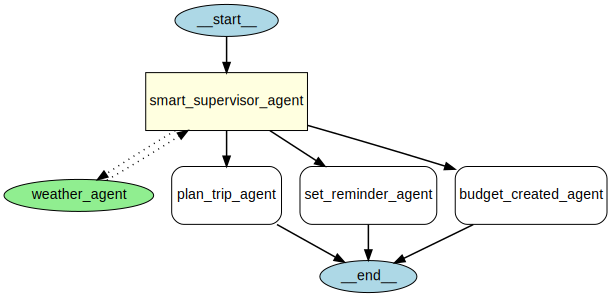

In [51]:
from agents.extensions.visualization import draw_graph
draw_graph(smart_supervisor_agent)

In [49]:
result=Runner.run_sync(smart_supervisor_agent,"What's the weather in Tokyo 2 july?" )
print(result.final_output)
print(result.to_input_list())

OK. I found some information about the weather in Tokyo in July 2025. The weather in Tokyo in July is generally hot with average temperatures between 24°C and 29°C. There are typically around 8 rainy days in July, with an average total precipitation of around 192 mm.

[{'content': "What's the weather in Tokyo 2 july?", 'role': 'user'}, {'arguments': '{"input":"What\'s the weather in Tokyo 2 july?"}', 'call_id': '', 'name': 'weather_agent', 'type': 'function_call', 'id': '__fake_id__'}, {'call_id': '', 'output': 'I found some information about the weather in Tokyo in July 2025. The weather in Tokyo in July is generally hot with average temperatures between 24°C and 29°C. There are typically around 8 rainy days in July, with an average total precipitation of around 192 mm.', 'type': 'function_call_output'}, {'id': '__fake_id__', 'content': [{'annotations': [], 'text': 'OK. I found some information about the weather in Tokyo in July 2025. The weather in Tokyo in July is generally hot with

In [ ]:
!pip install -Uq openai-agents tavily-python
import nest_asyncio
nest_asyncio.apply()

import os
from agents import Agent, Runner, AsyncOpenAI, OpenAIChatCompletionsModel
from google.colab import userdata

gemini_api_key = userdata.get("GEMINI_API_KEY")
search_api_key = userdata.get("SEARCH_API_KEY")

#Reference: https://ai.google.dev/gemini-api/docs/openai
external_client = AsyncOpenAI(
    api_key=gemini_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)

model = OpenAIChatCompletionsModel(
    model="gemini-2.0-flash",
    openai_client=external_client
)

from agents import set_tracing_disabled
set_tracing_disabled(True)

from pydantic import BaseModel
from agents import (
    Agent,
    GuardrailFunctionOutput,
    RunContextWrapper,
    Runner,
    TResponseInputItem,
    input_guardrail,
    output_guardrail,
    OutputGuardrailTripwireTriggered,

)

class TravelSafetyCheckOutput(BaseModel):
    is_unethical_or_illegal_request: bool
    reasoning: str

travel_guardrail_agent = Agent(
    name="Travel Guardrail",
    instructions=(
        "Determine if the user request involves illegal travel activity, such as crossing borders illegally, "
        "faking documents, or bypassing visa restrictions. Respond with reasoning."
    ),
    output_type=TravelSafetyCheckOutput,
    model=model # Ensure the model is used here as well
)

@input_guardrail
async def travel_guardrail(
    ctx: RunContextWrapper[None],
    agent: Agent,
    input: str | list[TResponseInputItem],
) -> GuardrailFunctionOutput:
    result = await Runner.run(travel_guardrail_agent, input, context=ctx.context)

    return GuardrailFunctionOutput(
        output_info=result.final_output,
        tripwire_triggered=result.final_output.is_unethical_or_illegal_request,
    )

class TripOutput(BaseModel):
    response: str

class TripSafetyCheck(BaseModel):
    reasoning: str
    contains_illegal_or_unrealistic: bool

trip_guardrail_agent = Agent(
    name="Trip Output Guardrail",
    instructions="Check if the travel plan contains illegal, unsafe, or unrealistic recommendations. Provide reasoning.",
    output_type=TripSafetyCheck,
    model=model
)

@output_guardrail
async def trip_output_guardrail(
    ctx: RunContextWrapper,
    agent: Agent,
    output: TripOutput
) -> GuardrailFunctionOutput:
    result = await Runner.run(trip_guardrail_agent, output.response, context=ctx.context)

    return GuardrailFunctionOutput(
        output_info=result.final_output,
        tripwire_triggered=result.final_output.contains_illegal_or_unrealistic,
    )

plan_trip_instructions = """You are a highly professional and meticulous
     trip planning agent. Your task is to generate detailed and
    well-structured itineraries based on the user's specified destination,
    duration, and interests. The itinerary should include a balanced mix of
    attractions, activities, and dining recommendations, taking into account
    geographical proximity and realistic travel times between locations. Ensure the plan is comprehensive, practical, and tailored to enhance the user's travel experience. """

from pydantic import BaseModel

class TripPlanOutput(BaseModel):
    response: str

plan_trip_agent=Agent(
    name="plan_trip_agent",
    instructions=plan_trip_instructions,
    model=model,
    input_guardrails=[travel_guardrail],
    output_guardrails=[trip_output_guardrail],
    output_type=TripPlanOutput
)

result= Runner.run_sync(plan_trip_agent,"i move usa for 30 days  " )
print(result.final_output)
print(result.to_input_list())

class FinanceSafetyCheckOutput(BaseModel):
    is_unethical_or_illegal_request: bool
    reasoning: str

finance_guardrail_agent = Agent(
    name="Finance Guardrail",
    instructions=(
        "Determine whether the user's request contains unethical or illegal financial content, such as tax fraud, "
        "loan evasion, or unrealistic get-rich-quick schemes. Provide a reasoned judgment."
    ),
    output_type=FinanceSafetyCheckOutput,
    model=model
)

@input_guardrail
async def finance_guardrail(
    ctx: RunContextWrapper[None],
    agent: Agent,
    input: str | list[TResponseInputItem],
) -> GuardrailFunctionOutput:
    result = await Runner.run(finance_guardrail_agent, input, context=ctx.context)

    return GuardrailFunctionOutput(
        output_info=result.final_output,
        tripwire_triggered=result.final_output.is_unethical_or_illegal_request,
    )

budget_created_instructions=""" You are a knowledgeable and reliable financial planning agent.
 Your role is to create clear, practical monthly budget plans based on the user's income, expenses,
  and savings goals. Analyze the input to calculate spending distribution and suggest strategies
  to optimize savings, reduce unnecessary expenses, and achieve long-term financial stability.
Ensure your guidance is personalized, realistic, and easy to follow."""

class BudgetOutput(BaseModel):
    response: str

class BudgetSafetyCheck(BaseModel):
    reasoning: str
    contains_unethical_finance: bool

budget_guardrail_agent = Agent(
    name="Budget Output Guardrail",
    instructions="Check if the budget advice includes unethical, unsafe, or illegal financial strategies. Provide reasoning.",
    output_type=BudgetSafetyCheck,
    model=model
)

@output_guardrail
async def budget_output_guardrail(
    ctx: RunContextWrapper,
    agent: Agent,
    output: BudgetOutput
) -> GuardrailFunctionOutput:
    result = await Runner.run(budget_guardrail_agent, output.response, context=ctx.context)

    return GuardrailFunctionOutput(
        output_info=result.final_output,
        tripwire_triggered=result.final_output.contains_unethical_finance,
    )

budget_created_agent=Agent(
    name="budget_created_agent",
    instructions=budget_created_instructions,
    model=model,
    input_guardrails=[finance_guardrail],
    output_guardrails=[budget_output_guardrail],
    output_type=BudgetOutput
)

result=Runner.run_sync(budget_created_agent,"i can move USA need money " )
print(result.final_output)

from pydantic import BaseModel
from agents import (
    Agent,
    GuardrailFunctionOutput,
    RunContextWrapper,
    Runner,
    TResponseInputItem,
    input_guardrail,
    output_guardrail,
    OutputGuardrailTripwireTriggered,

)

class ReminderCheckOutput(BaseModel):
    reasoning: str
    # is_malicious_or_concerning: bool # This was the old name, now using contains_harmful_reminder

reminder_guardrail_agent = Agent(
    name="Reminder Guardrail",
    instructions=(
        "Check if the reminder request is potentially harmful, threatening, or abusive — such as reminders for violent acts "
        "or unethical actions. Explain your reasoning."
    ),
    output_type=ReminderCheckOutput,
    model=model
)

@input_guardrail
async def reminder_guardrail(
    ctx: RunContextWrapper[None],
    agent: Agent,
    input: str | list[TResponseInputItem],
) -> GuardrailFunctionOutput:
    result = await Runner.run(reminder_guardrail_agent, input, context=ctx.context)

    return GuardrailFunctionOutput(
        output_info=result.final_output,
        tripwire_triggered=result.final_output.contains_harmful_reminder,
    )

set_reminder_instructions=""" You are a precise and dependable personal assistant
specializing in task management and reminders. Your responsibility is to schedule
reminders based on the user’s specified task and date/time. Confirm all details clearly
and ensure that the reminders are timely, actionable, and unambiguous.
 Always prioritize clarity and accuracy to help users stay organized and on track."""

class ReminderOutput(BaseModel):
    response: str

class ReminderSafetyCheck(BaseModel):
    reasoning: str
    contains_harmful_reminder: bool

reminder_guardrail_agent = Agent(
    name="Reminder Output Guardrail",
    instructions="Check if the reminder includes anything harmful, suspicious, or unethical. Provide reasoning.",
    output_type=ReminderSafetyCheck,
    model=model
)

@output_guardrail
async def reminder_output_guardrail(
    ctx: RunContextWrapper,
    agent: Agent,
    output: ReminderOutput
) -> GuardrailFunctionOutput:
    result = await Runner.run(reminder_guardrail_agent, output.response, context=ctx.context)

    return GuardrailFunctionOutput(
        output_info=result.final_output,
        tripwire_triggered=result.final_output.contains_harmful_reminder,
    )

set_reminder_agent=Agent(
    name="set_reminder_agent",
    instructions=set_reminder_instructions,
    model=model,
    input_guardrails=[reminder_guardrail],
    output_guardrails=[reminder_output_guardrail],
    output_type=ReminderOutput
)

result=Runner.run_sync(set_reminder_agent,"i can move USA  " )
print(result.final_output)

weather_instructions=""" You are a helpful and accurate weather assistant.
Your task is to provide current or forecasted weather information for a given location and date.
Summarize conditions clearly, including temperature, precipitation, and any important alerts.
 When a date is not specified, default to today’s forecast.
Present information in a user-friendly format to help users plan their activities accordingly."""

from agents.tool import function_tool
from tavily import TavilyClient

@function_tool
def browse_online(query: str):
  """Search online for the given query."""
  tavily_client = TavilyClient(api_key=search_api_key)
  response = tavily_client.search(query)
  return response

weather_agent=Agent(
    name="weather_agent",
    instructions=weather_instructions,
    model=model,
    tools=[browse_online]
)

result=Runner.run_sync(weather_agent,"what is weather in USA today" )
print(result.final_output)

smart_supervisor_instructions="""You are a highly intelligent and organized supervisor agent
responsible for managing and coordinating multiple specialized agents. Your task is to interpret
user input, determine the appropriate agent or function to handle the request, and delegate the
task accordingly. You ensure that each request is routed correctly — whether it's travel planning,
 budgeting, reminders, or weather — and maintain a smooth, coherent conversation. If user intent is unclear, ask clarifying questions.
 Always aim to deliver helpful, relevant, and efficient outcomes."""

from agents import handoff
smart_supervisor_agent=Agent(
    name="smart_supervisor_agent",
    instructions=smart_supervisor_instructions,
    model=model,
    tools=[
        weather_agent.as_tool(
            tool_name="weather_agent",
            tool_description="Search online for the given query."
        )
    ],
    handoffs=[plan_trip_agent,set_reminder_agent]
)

from agents.extensions.visualization import draw_graph
draw_graph(smart_supervisor_agent)

result=Runner.run_sync(smart_supervisor_agent,"What's the weather in Tokyo 2 july?" )
print(result.final_output)
print(result.to_input_list())